# ทดสอบรวมฝนรายชั่วโมงเป็นฝนรายวัน ใช้คอลัมน์ full_date และ code พลอต density ใช้ ZR RF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import linregress
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## read cleansing 

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
#df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events/df_org_dbz_rain_test200km.csv')
df.drop(df[df['cappi4km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df
#df.head()

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


### เปลี่ยนชื่อคอลัมน์

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0
...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0


### คำนวน rain estimates จาก ZRs

In [4]:
## แปลง cappi เป็นฝนรายชั่วโมง ด้วย ZRs
### ZR Rosenfeld
a=250. 
b=1.2
df['rr_RF_c1']=((10**(df['dBZ_c1']/10.))/a)**(1/b)
df['rr_RF_c2']=((10**(df['dBZ_c2']/10.))/a)**(1/b)
df['rr_RF_c3']=((10**(df['dBZ_c3']/10.))/a)**(1/b)
df['rr_RF_c4']=((10**(df['dBZ_c4']/10.))/a)**(1/b)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,24.691301,24.196701,20.083112,20.643747,2018-06-01-00:00,CMSG,0.0,1.146371,1.042578,0.473488,0.527265
1,25.330028,23.526070,23.449750,24.210546,2018-06-01-00:00,KGTP,0.0,1.295843,0.916690,0.903363,1.045351
2,27.172401,27.172401,27.172403,27.172401,2018-06-01-00:00,LPLE,0.0,1.845370,1.845370,1.845371,1.845370
3,22.804799,24.250445,26.664243,27.962598,2018-06-01-00:00,NAN011,0.0,0.798209,1.053385,1.673928,2.147500
4,20.640297,20.409634,19.715693,19.201311,2018-06-01-00:00,SLBC,0.0,0.526916,0.504103,0.441256,0.399784
...,...,...,...,...,...,...,...,...,...,...,...
8656,16.701266,15.322284,13.358064,12.000171,2018-09-21-16:00,TPKO,0.0,0.247451,0.189921,0.130283,0.100399
8657,24.601331,24.696486,24.310151,23.377122,2018-09-21-17:00,CNDN,0.2,1.126750,1.147512,1.065522,0.890861
8658,32.678558,31.940033,31.637293,30.511404,2018-09-21-17:00,NAN005,0.0,5.307987,4.606659,4.346681,3.502141
8659,26.931454,26.879102,18.453910,23.309853,2018-09-21-17:00,NGBA,0.0,1.761994,1.744383,0.346372,0.879436


In [5]:
## ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,2018-06-01-00:00,CMSG,0.0,1.146371,1.042578,0.473488,0.527265
1,2018-06-01-00:00,KGTP,0.0,1.295843,0.916690,0.903363,1.045351
2,2018-06-01-00:00,LPLE,0.0,1.845370,1.845370,1.845371,1.845370
3,2018-06-01-00:00,NAN011,0.0,0.798209,1.053385,1.673928,2.147500
4,2018-06-01-00:00,SLBC,0.0,0.526916,0.504103,0.441256,0.399784
...,...,...,...,...,...,...,...
8656,2018-09-21-16:00,TPKO,0.0,0.247451,0.189921,0.130283,0.100399
8657,2018-09-21-17:00,CNDN,0.2,1.126750,1.147512,1.065522,0.890861
8658,2018-09-21-17:00,NAN005,0.0,5.307987,4.606659,4.346681,3.502141
8659,2018-09-21-17:00,NGBA,0.0,1.761994,1.744383,0.346372,0.879436


### รวมฝนรายชั่วโมงเป็นรายวัน ด้วยการสร้างคอลัมน์ date_only เพือ่ใช้ร่วมกับคอลัมน์ code

In [6]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

# The resulting DataFrame 'aggregated_data' will have the aggregated values
print(aggregated_data)

       date_only    code  rain_truth   rr_RF_c1   rr_RF_c2   rr_RF_c3  \
0     2018-06-01    BPPS         0.2   1.577677   1.305313   1.509974   
1     2018-06-01    CMSG         4.8  19.252761  16.897112  16.697594   
2     2018-06-01    CNDN         0.0   8.791119  11.013447   5.478229   
3     2018-06-01  DIV003         0.0   3.103048   2.563887   2.607401   
4     2018-06-01  DIV005         0.0   0.528164   0.530831   0.734303   
...          ...     ...         ...        ...        ...        ...   
1955  2018-09-21  NAN008         0.0   0.475234   0.475234   0.475234   
1956  2018-09-21    NGBA         0.0   1.761994   1.744383   0.346372   
1957  2018-09-21  PIN003         2.4  53.841734  54.647951  42.881720   
1958  2018-09-21    TGSK         0.0   0.801745   0.753511   0.808269   
1959  2018-09-21    TPKO         0.0   0.247451   0.189921   0.130283   

       rr_RF_c4  
0      1.942876  
1     18.567472  
2      4.158776  
3      2.405885  
4      0.934186  
...         ...

In [7]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
df_=df_[df_['rr_RF_c1']>0]

In [8]:
df_.reset_index(drop=True, inplace=True)

In [9]:
df_.describe()

,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
count,961.000000,961.000000,961.000000,961.000000,961.000000
mean,6.129448,17.857101,17.011808,16.547400,15.984553
std,9.208948,34.371919,31.698243,29.903933,31.278439
min,0.200000,0.082884,0.077979,0.088946,0.076046
25%,0.400000,3.154635,3.251440,3.358838,3.415329
50%,2.000000,6.741200,6.968069,7.652011,7.418207
75%,7.800000,15.947656,16.789942,17.571704,16.779570
max,77.800000,365.000616,361.679610,345.036764,553.876923


In [10]:
df_.corr()

,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
rain_truth,1.000000,0.481666,0.474909,0.507287,0.421055
rr_RF_c1,0.481666,1.000000,0.931125,0.800797,0.601413
rr_RF_c2,0.474909,0.931125,1.000000,0.888066,0.664441
rr_RF_c3,0.507287,0.800797,0.888066,1.000000,0.881573
rr_RF_c4,0.421055,0.601413,0.664441,0.881573,1.000000


## พลอต scatter คำนวณสถิติ และ พลอตค่า metrics

In [11]:
def density_plot(rain_truth, rain_radar):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)

    
    max_ = 50
    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_truth [mm/hr]')
    plt.ylabel('rain_radar [mm/hr]')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Plot the regression line
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')
    plt.legend()

    # Display the plot
    plt.show()


RMSE: 33.13379318168193
MSE: 1097.8482506064718
MAE: 13.75999700239652
R-squared: 0.06977734021913029
Correlation coefficient (r): 0.4816660929508058
P-value: 5.71202081878229e-57


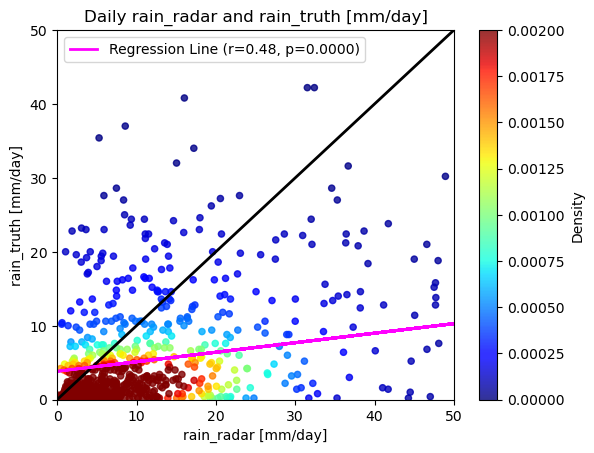

In [12]:
density_plot(df_['rain_truth'],df_['rr_RF_c1'])

RMSE: 30.494344455269818
MSE: 929.9050437566451
MAE: 12.60007133617315
R-squared: 0.07355342440673818
Correlation coefficient (r): 0.4749085993236888
P-value: 3.2231154780757353e-55


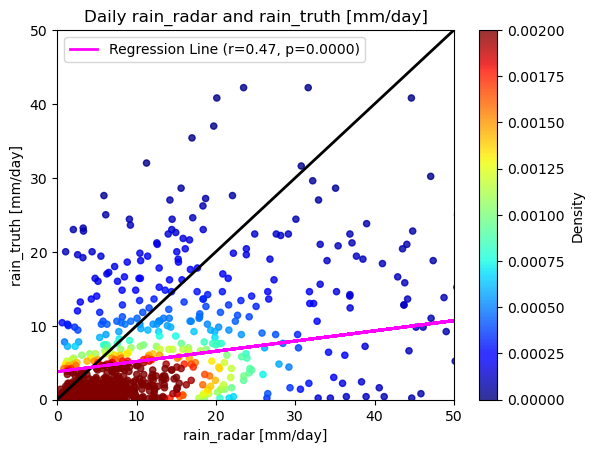

In [13]:
density_plot(df_['rain_truth'],df_['rr_RF_c2'])

RMSE: 28.415816954450914
MSE: 807.45865318886
MAE: 11.932803794855156
R-squared: 0.09610949077742947
Correlation coefficient (r): 0.5072865240929926
P-value: 5.601416059064052e-64


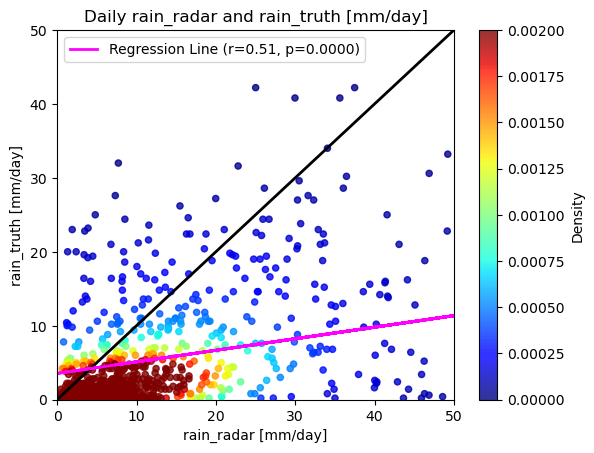

In [14]:
density_plot(df_['rain_truth'],df_['rr_RF_c3'])

RMSE: 30.279566508431916
MSE: 916.8521479385518
MAE: 11.663084579537284
R-squared: 0.06187368193106557
Correlation coefficient (r): 0.4210548022874809
P-value: 1.3997738350582854e-42


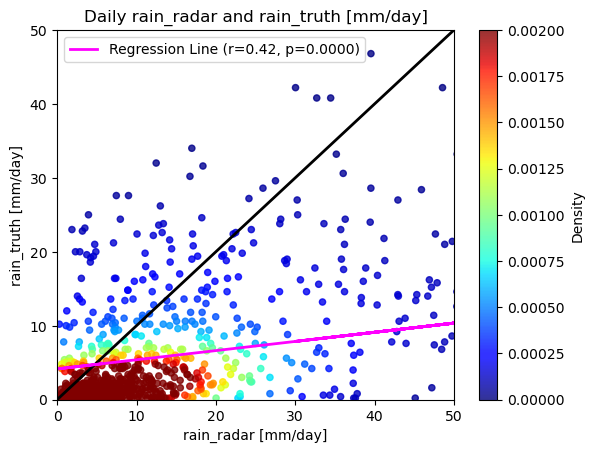

In [15]:
density_plot(df_['rain_truth'],df_['rr_RF_c4'])

### คำนวณสถิติ และ พลอตค่า metrics

In [16]:
def density_plot_joint(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=20, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')
    
    max_=50

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm/day]')
    plt.ylabel('rain_truth [mm/day]')
    plt.title('Daily rain_radar and rain_truth [mm/day]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()


RMSE: 33.133793181681924
MSE: 1097.8482506064715
MAE: 13.759997002396522
R-squared: 0.06977734021913029
Correlation coefficient (r): 0.4816660929508052
P-value: 5.712020818784409e-57


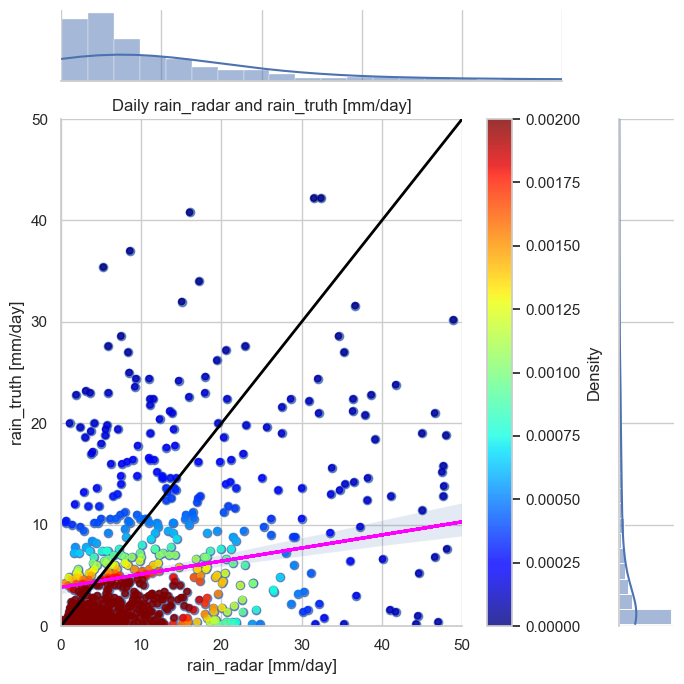

In [17]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c1'])

RMSE: 30.49434445526982
MSE: 929.9050437566452
MAE: 12.60007133617315
R-squared: 0.07355342440673807
Correlation coefficient (r): 0.47490859932368823
P-value: 3.2231154780768854e-55


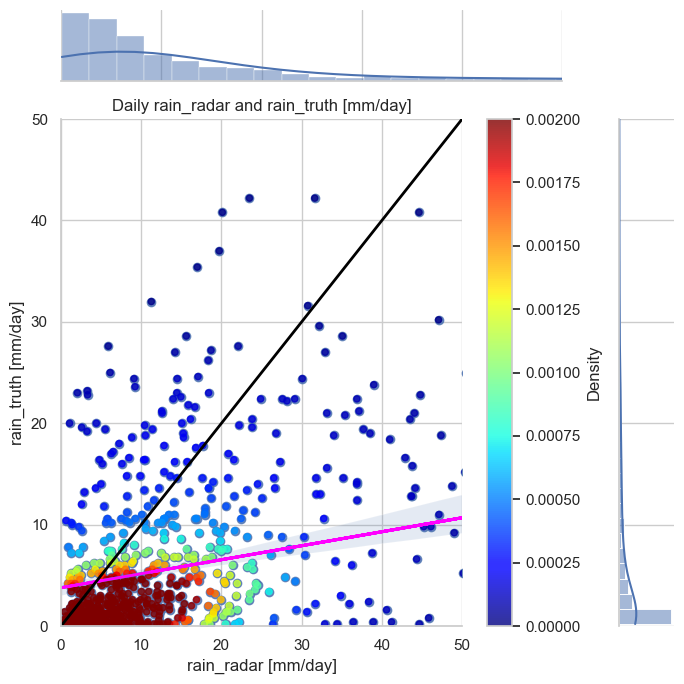

In [18]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c2'])

RMSE: 28.415816954450914
MSE: 807.45865318886
MAE: 11.932803794855154
R-squared: 0.0961094907774298
Correlation coefficient (r): 0.5072865240929921
P-value: 5.6014160590653305e-64


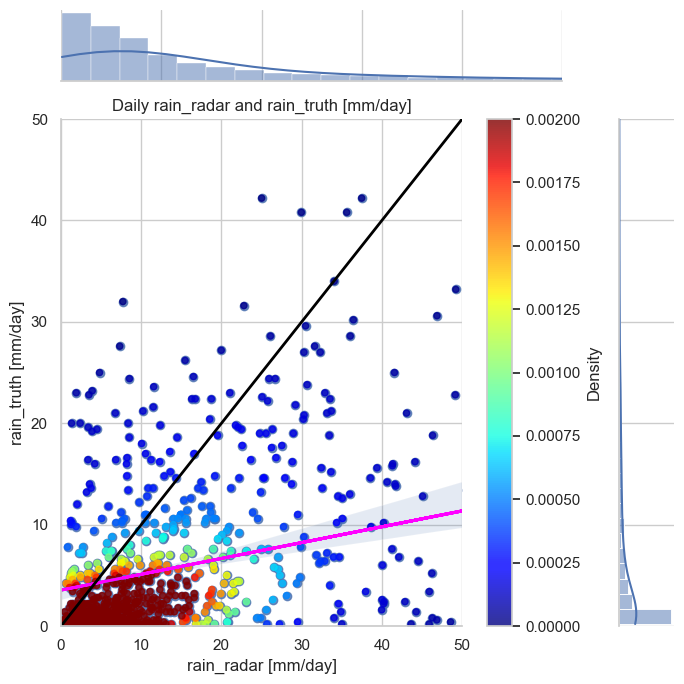

In [19]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c3'])

RMSE: 30.279566508431916
MSE: 916.8521479385518
MAE: 11.663084579537284
R-squared: 0.06187368193106568
Correlation coefficient (r): 0.42105480228748027
P-value: 1.3997738350586657e-42


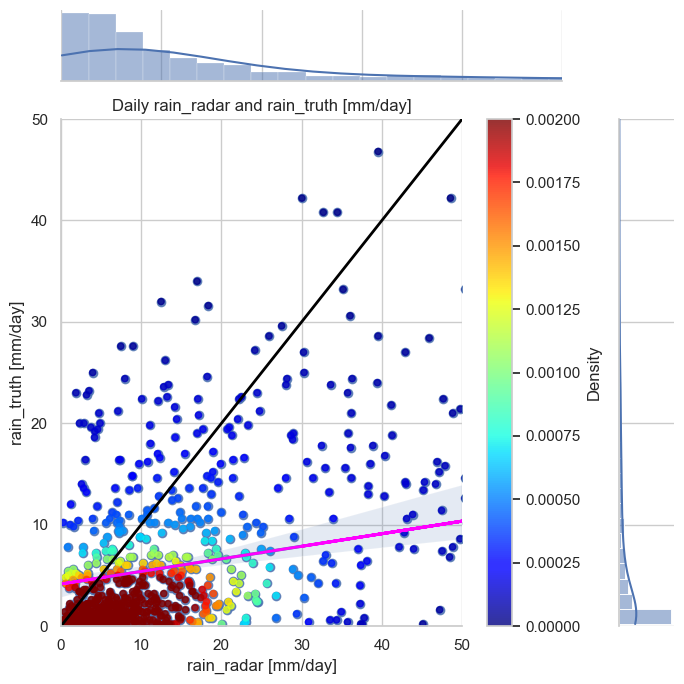

In [20]:
density_plot_joint(df_['rain_truth'],df_['rr_RF_c4'])

## รวมฝนรายวันเป็นฝนทั้งเหตุการณ์ของแต่ละสถานี

In [21]:
def density_plot_joint_events(rain_truth,rain_radar):
    # data
    x = rain_radar
    y = rain_truth

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Print results
    print(f'RMSE: {rmse}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'R-squared: {r2}')
    print(f'Correlation coefficient (r): {r_value}')
    print(f'P-value: {p_value}')

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Set the desired colorbar range
    cbar_min = 0  # specify your minimum value
    cbar_max = 0.002  # specify your maximum value

    # Create a joint plot with scatter plot, regression line, and density plot
    sns.set(style="whitegrid")
    g = sns.jointplot(x=x, y=y, kind="reg", height=7)
    plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
             label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    #plt.text(0.5, 0.9, f'r = {r_value:.2f}, p = {p_value:.4f}', horizontalalignment='center', verticalalignment='center', transform=g.ax_joint.transAxes)

    # Add scatter plot with density color map
    scatter = plt.scatter(x, y, c=z, s=10, cmap='jet', alpha=0.8, vmin=cbar_min, vmax=cbar_max)
    
    # Set scatter plot aspect ratio to be equal
    #plt.gca().set_aspect('equal', adjustable='box')

    # Set x and y axis limits
    max_=50
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='-', color='black', linewidth=2)

    plt.xlabel('rain_radar [mm]')
    plt.ylabel('rain_truth [mm]')
    plt.title('Events rain_radar and rain_truth [mm]')

    # Add colorbar using the scatter variable
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [22]:
df_

,date_only,code,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
0,2018-06-01,BPPS,0.2,1.577677,1.305313,1.509974,1.942876
1,2018-06-01,CMSG,4.8,19.252761,16.897112,16.697594,18.567472
2,2018-06-01,KGKG,0.4,3.448033,3.715793,4.340454,4.199824
3,2018-06-01,KGLN,0.2,12.891184,12.727793,11.770244,13.174971
4,2018-06-01,KOKO,19.4,5.558886,11.398203,22.486366,17.700838
...,...,...,...,...,...,...,...
956,2018-09-20,TGSK,1.0,3.534080,3.910491,4.778155,5.158574
957,2018-09-20,TSLM,1.0,1.230703,1.222699,1.199904,1.092110
958,2018-09-20,VLGE15,0.4,2.117947,2.006200,1.879645,1.744397
959,2018-09-21,CNDN,0.2,1.458931,1.445089,1.380657,1.221706


In [23]:
import pandas as pd

# Assuming df_ is your DataFrame
# Group by 'code' and calculate the mean for each group
aggregated_df = df_.groupby('code').mean().reset_index()

# Display the aggregated DataFrame
print("Aggregated DataFrame:")
df_=aggregated_df
print(df_)


Aggregated DataFrame:
      code  rain_truth   rr_RF_c1   rr_RF_c2   rr_RF_c3   rr_RF_c4
0     BDLH    6.684211  11.163951   9.111548   9.015743   7.603014
1     BMNK    1.000000   6.456459   4.174805   6.802340   4.228620
2     BPPS    5.626667  20.614707  17.468402  15.359016  13.772359
3     CMSG    6.500000  23.785387  20.810479  16.418645  13.419374
4     CNDN   11.982609  38.793925  27.373982  23.990275  20.472332
..     ...         ...        ...        ...        ...        ...
63    WSPN    4.608696   8.889109  12.092218  11.836795  12.365474
64  YOM005    5.400000  41.334089  38.549480  34.406045  31.892892
65  YOM006    4.323077  10.014419   9.205308  12.204393  12.077946
66  YOM009    6.740000  23.268162  20.099941  18.178779  18.779822
67  YOM012    0.400000   4.590652   3.193701   4.493517   5.160641

[68 rows x 6 columns]


In [24]:
df_.corr()

,rain_truth,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4
rain_truth,1.000000,0.427732,0.325753,0.330624,0.324908
rr_RF_c1,0.427732,1.000000,0.837551,0.670906,0.577584
rr_RF_c2,0.325753,0.837551,1.000000,0.939302,0.837985
rr_RF_c3,0.330624,0.670906,0.939302,1.000000,0.950446
rr_RF_c4,0.324908,0.577584,0.837985,0.950446,1.000000


RMSE: 18.20889805103753
MSE: 331.56396823307836
MAE: 13.151292236152731
R-squared: -0.7470292778094645
Correlation coefficient (r): 0.42773180076520795
P-value: 0.0002744698938168992


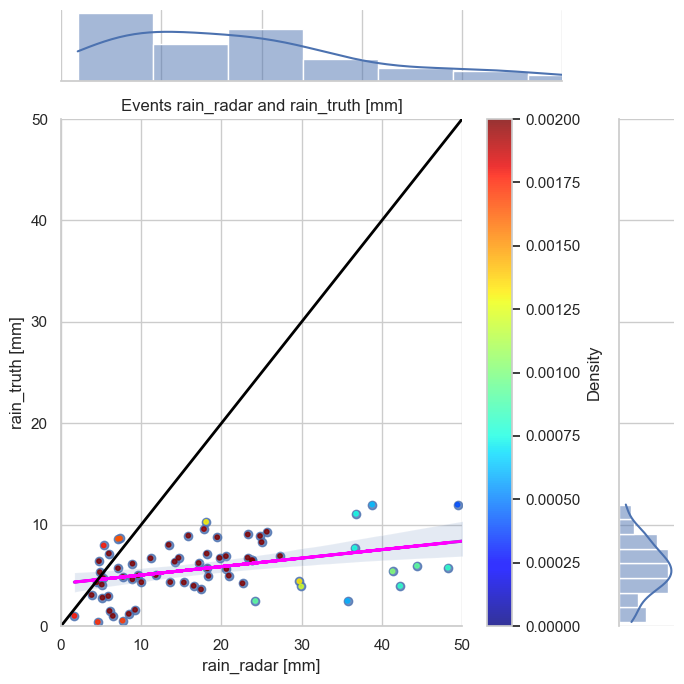

In [25]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c1'])

RMSE: 19.713514777653447
MSE: 388.6226648887608
MAE: 12.816901983673423
R-squared: -0.5721579651112116
Correlation coefficient (r): 0.32575349596967473
P-value: 0.00671212791520204


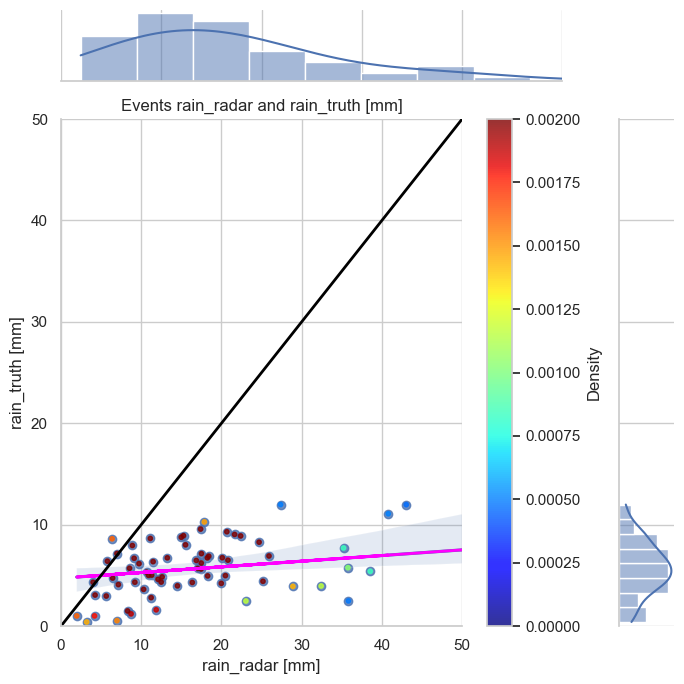

In [26]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c2'])

RMSE: 19.40908121522636
MSE: 376.71243361925286
MAE: 12.272686105476549
R-squared: -0.49662115355650327
Correlation coefficient (r): 0.330623942381131
P-value: 0.005891659368668036


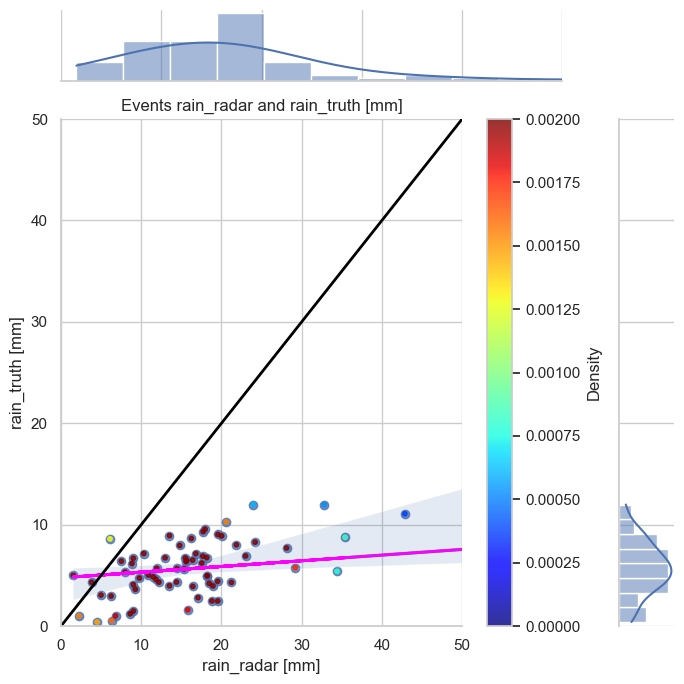

In [27]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c3'])

RMSE: 17.49402769668208
MSE: 306.0410050522796
MAE: 11.136045880439346
R-squared: -0.5103309836091292
Correlation coefficient (r): 0.32490814389073475
P-value: 0.006864321353919924


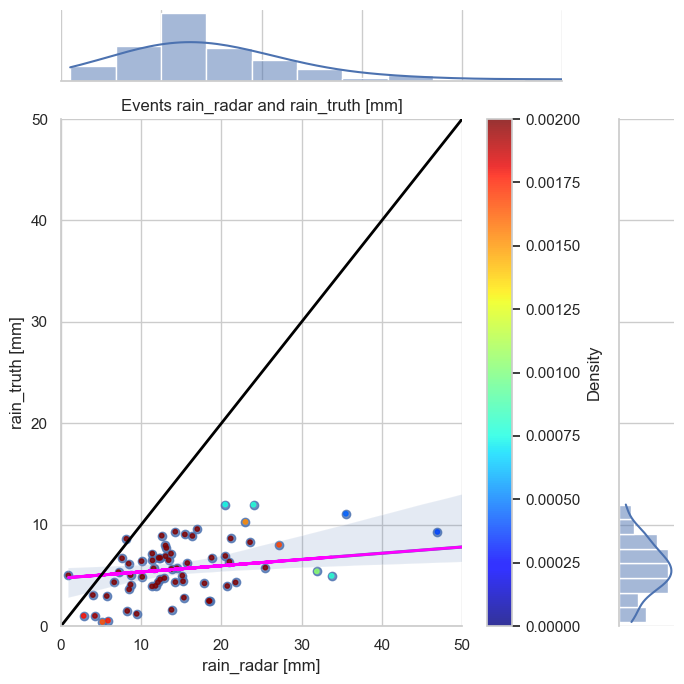

In [28]:
density_plot_joint_events(df_['rain_truth'],df_['rr_RF_c4'])

## หา bias และปรับแก้แบบ MFB Mean Field Bias Correction